# Libraries

In [2]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [3]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, digital_filter_design, rf_rx_dfe, digital_operations as digops

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rf_rx_dfe)
reload(digops)

<module 'rfdsppy.digital_operations' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_operations.py'>

# Notch Filter

EVM: 70.9%
SNR: 2.987dB


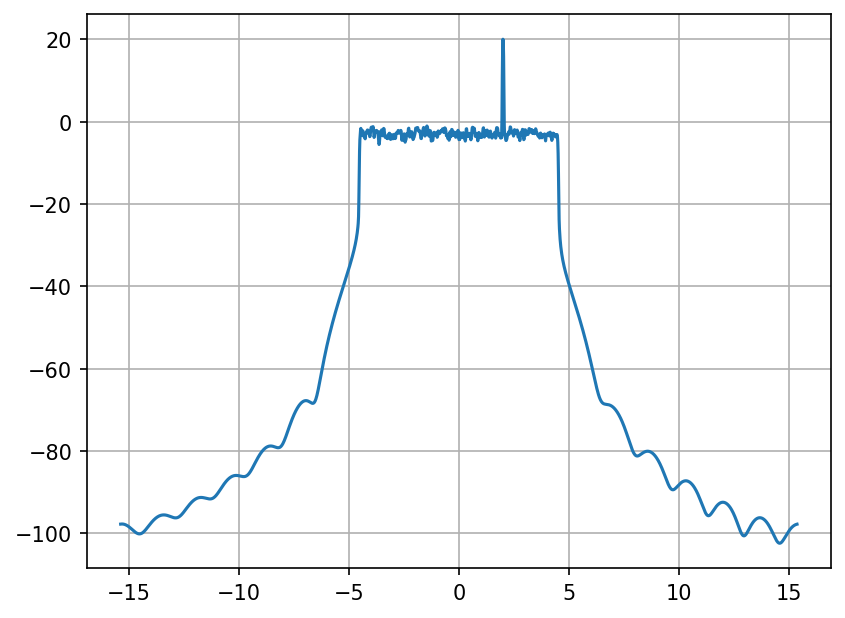

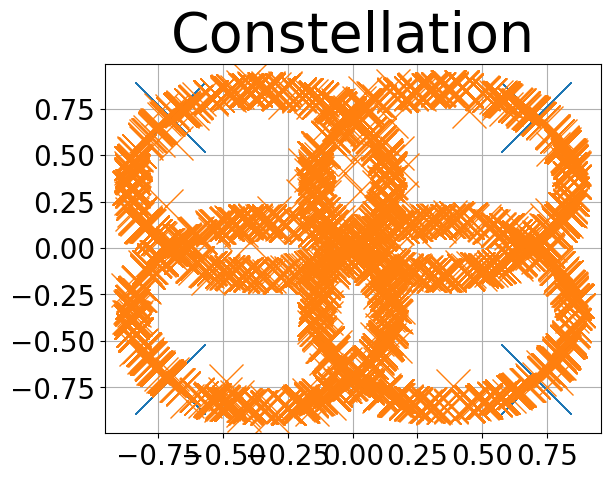

In [13]:
modorder = 4
bw = 20
scs = 15
num_sc = 50*12
start_sc = 600-round(num_sc/2)
en_tprecode = True
osr = 1
wola = 1
ofdm_wavgen = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola, power=0)

x_sig, x_standard = ofdm_wavgen.generate(14)
cfg = ofdm_wavgen.get_demod_params()
fs = cfg.get("fs")

rng = np.random.default_rng()
fspur = 2
spur = tonegen.tonegen(fs, fspur, cossin="exp", nsamp=x_sig.size, theta0=rng.uniform(low=-np.pi, high=np.pi), power=0)

x = x_sig+spur

p, f = calc.psd(x, fs, fs/2048)
p = calc.scale_psd(p, f, bw, scs, start_sc, num_sc)
fig, axs = plt.subplots(dpi=150)
axs.plot(f, 10*np.log10(p))
axs.grid()

evm = ofdm_wavgen.calculate_evm(x_standard, x[round(cfg.get("wola_len")/2):], en_plot=True)
snr = -20*np.log10(evm/100)
print(f"EVM: {evm.round(3)}%")
print(f"SNR: {snr.round(3)}dB")

EVM: 9.362%
SNR: 20.573dB


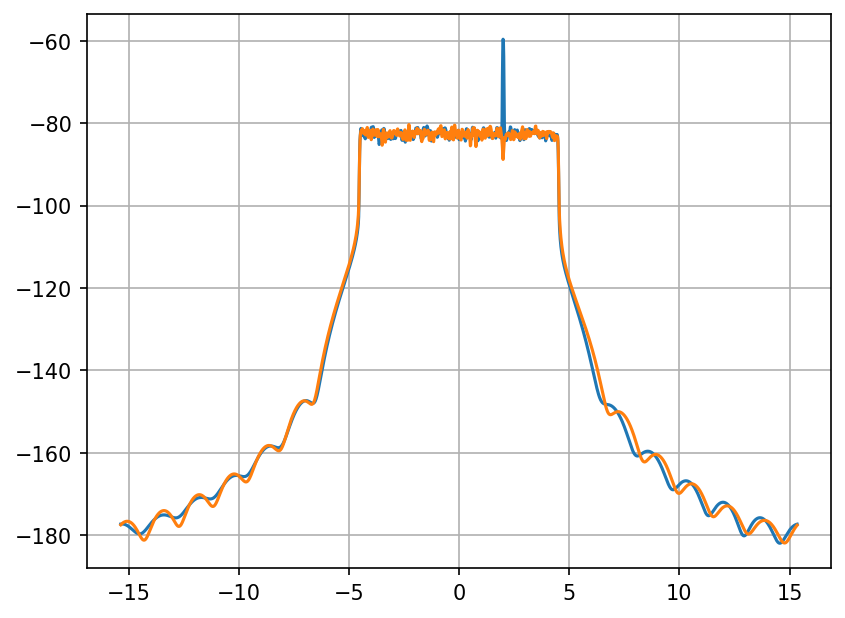

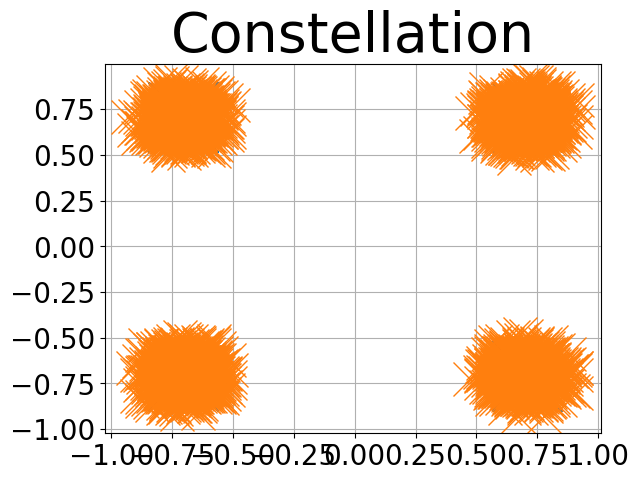

In [36]:
w0 = fspur*2*np.pi/fs
r = 0.995

notch = rf_rx_dfe.NotchFilter(w0, r)
y = notch.transform(x)

# fig, axs = plt.subplots(dpi=150)
# axs.plot(np.abs(x[:300]), label="Notch Input")
# axs.plot(np.abs(y[:300]), label="Notch Output")
# axs.legend()
# axs.grid()

x_start = 2*(cfg.get("nfft")+cfg.get("ncp"))
start_index = x_start+round(cfg.get("wola_len")/2)

fig, axs = plt.subplots(dpi=150)
p, f = calc.psd(x, fs, fs/2048)
axs.plot(f, 10*np.log10(p), label="Notch Input")
p, f = calc.psd(y[start_index:], fs, fs/2048)
axs.plot(f, 10*np.log10(p), label="Notch Output")
axs.grid()

evm = ofdm_wavgen.calculate_evm(x_standard[x_start:], y[start_index:], en_plot=True)
snr = -20*np.log10(evm/100)
print(f"EVM: {evm.round(3)}%")
print(f"SNR: {snr.round(3)}dB")

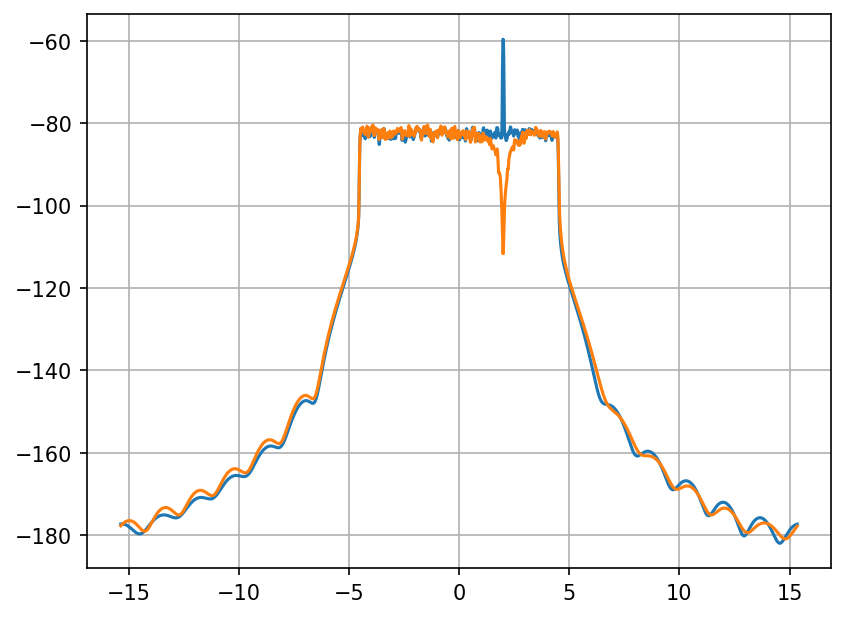

EVM: 39.974%
SNR: 7.965dB


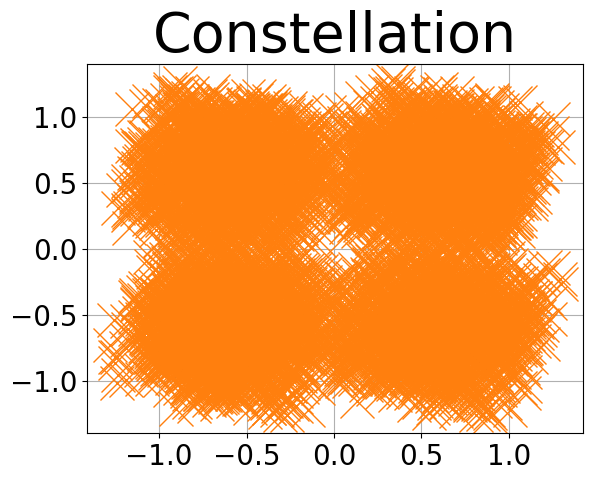